In [1]:
import sys
sys.path.append("..")

from datetime import datetime
import numpy as np
import ujson as json
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from lib.dataclasses import SignalDCT, SignalTime, SingleSample, Sample, SignalSpectrum
from lib.utils import get_sample_from_json
from copy import deepcopy

In [2]:
plt.style.use('ggplot')
from matplotlib.gridspec import GridSpec

In [3]:
PATH_TO_DATASET_1 = "/workspaces/project/raw/sequence_1/"
PATH_TO_DATASET_2 = "/workspaces/project/raw/sequence_2/"

# Importing data

In [4]:
band_limits = [
    0,
    5,
    20,
    32,
    40,
    55,
    75,
    100,
    120,
    128
]

In [5]:
band_pairs = [(band_limits[i], band_limits[i+1]) for i in range(len(band_limits)-1)]

Dataset 1

In [29]:
valid_date = datetime(2022, 11, 18, 10, 19)

band_matrices_dataset_1 = {f"{cable}": [] for cable in range(4)}
tensions_dataset_1 = {f"{cable}": [] for cable in range(4)}
for file_path in tqdm(os.listdir(PATH_TO_DATASET_1)):
    sample_id = file_path.split(".json")[0]
    date = datetime.strptime(sample_id, "%Y_%m_%d_%H_%M")
    if date >= valid_date:
        sample = get_sample_from_json(
            path = PATH_TO_DATASET_1 + file_path,
            sample_id=sample_id
        )

        for cable in range(4):
            band_matrix = np.zeros(len(band_pairs))
            for j, pair in enumerate(band_pairs):
                band_matrix[j] = sample[cable]["y"].get_energy([pair[0], pair[1]]) + sample[cable]["z"].get_energy([pair[0], pair[1]]) 
            band_matrices_dataset_1[f"{cable}"].append(band_matrix)
            tensions_dataset_1[f"{cable}"].append(sample[cable].tension)

for cable in range(4):
    band_matrices_dataset_1[f"{cable}"] = np.array(band_matrices_dataset_1[f"{cable}"])
        

100%|██████████| 2865/2865 [01:00<00:00, 47.56it/s] 


Dataset 2

In [28]:
valid_date = datetime(2023, 1, 7, 10, 00)

band_matrices_dataset_2 = {f"{cable}": [] for cable in range(4)}
tensions_dataset_2 = {f"{cable}": [] for cable in range(4)}
for file_path in tqdm(os.listdir(PATH_TO_DATASET_2)):
    sample_id = file_path.split(".json")[0]
    date = datetime.strptime(sample_id, "%Y_%m_%d_%H_%M")
    if date >= valid_date:
        sample = get_sample_from_json(
            path = PATH_TO_DATASET_2 + file_path,
            sample_id=sample_id
        )

        for cable in range(4):
            band_matrix = np.zeros(len(band_pairs))
            for j, pair in enumerate(band_pairs):
                band_matrix[j] = sample[cable]["y"].get_energy([pair[0], pair[1]]) + sample[cable]["z"].get_energy([pair[0], pair[1]]) 
            band_matrices_dataset_2[f"{cable}"].append(band_matrix)
            tensions_dataset_2[f"{cable}"].append(sample[cable].tension)

for cable in range(4):
    band_matrices_dataset_2[f"{cable}"] = np.array(band_matrices_dataset_2[f"{cable}"])
        

100%|██████████| 4420/4420 [01:41<00:00, 43.61it/s]


In [30]:
band_matrices_dataset_2["0"].shape

(4404, 9)

# Visualization

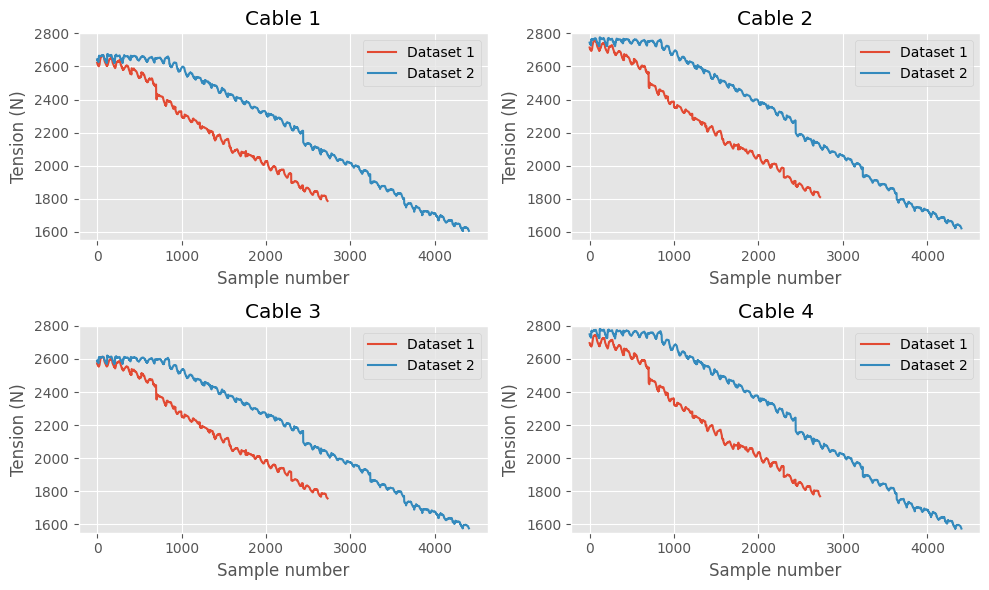

In [41]:
plt.figure(figsize=(10,6))

for cable in range(4):
    plt.subplot(2,2,cable+1)
    plt.title(f"Cable {cable+1}")
    plt.plot(tensions_dataset_1[f"{cable}"])
    plt.plot(tensions_dataset_2[f"{cable}"])
    plt.legend(["Dataset 1", "Dataset 2"])
    plt.ylim([1550, 2800])
    plt.xlabel("Sample number")
    plt.ylabel("Tension (N)")
plt.tight_layout()

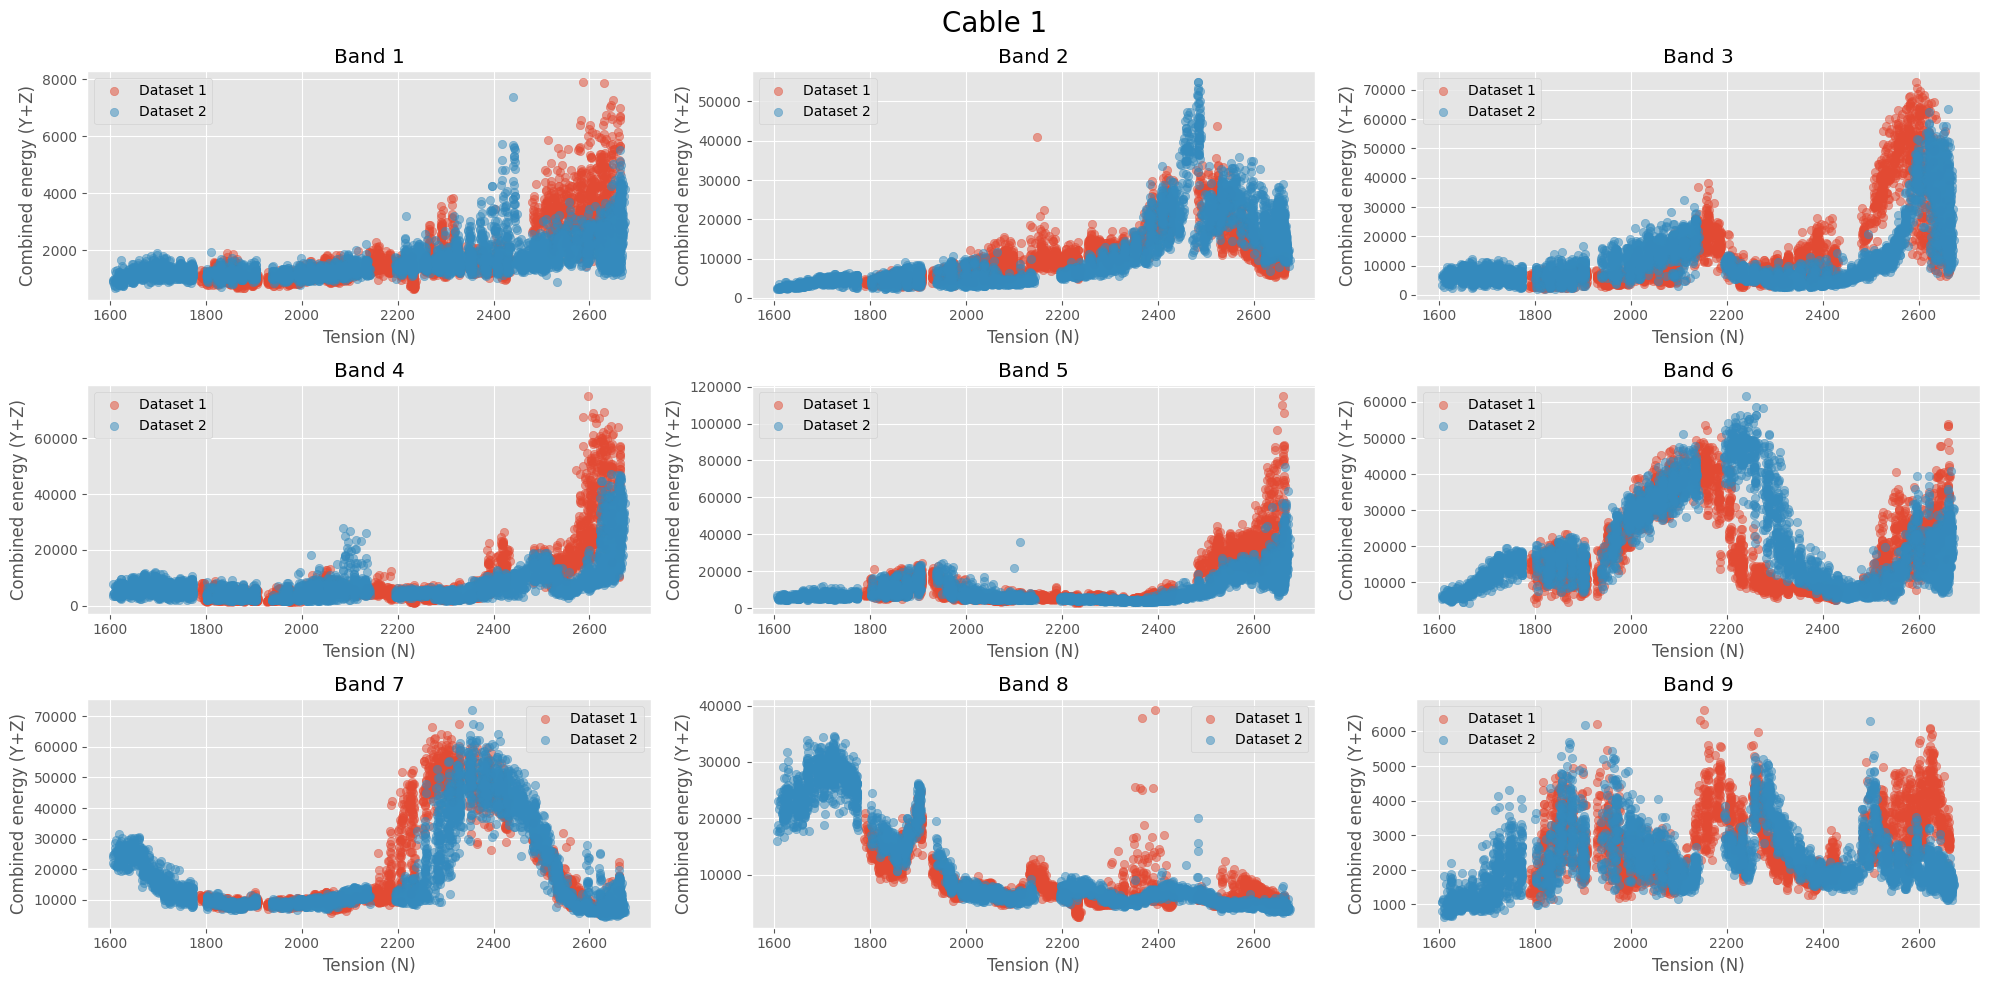

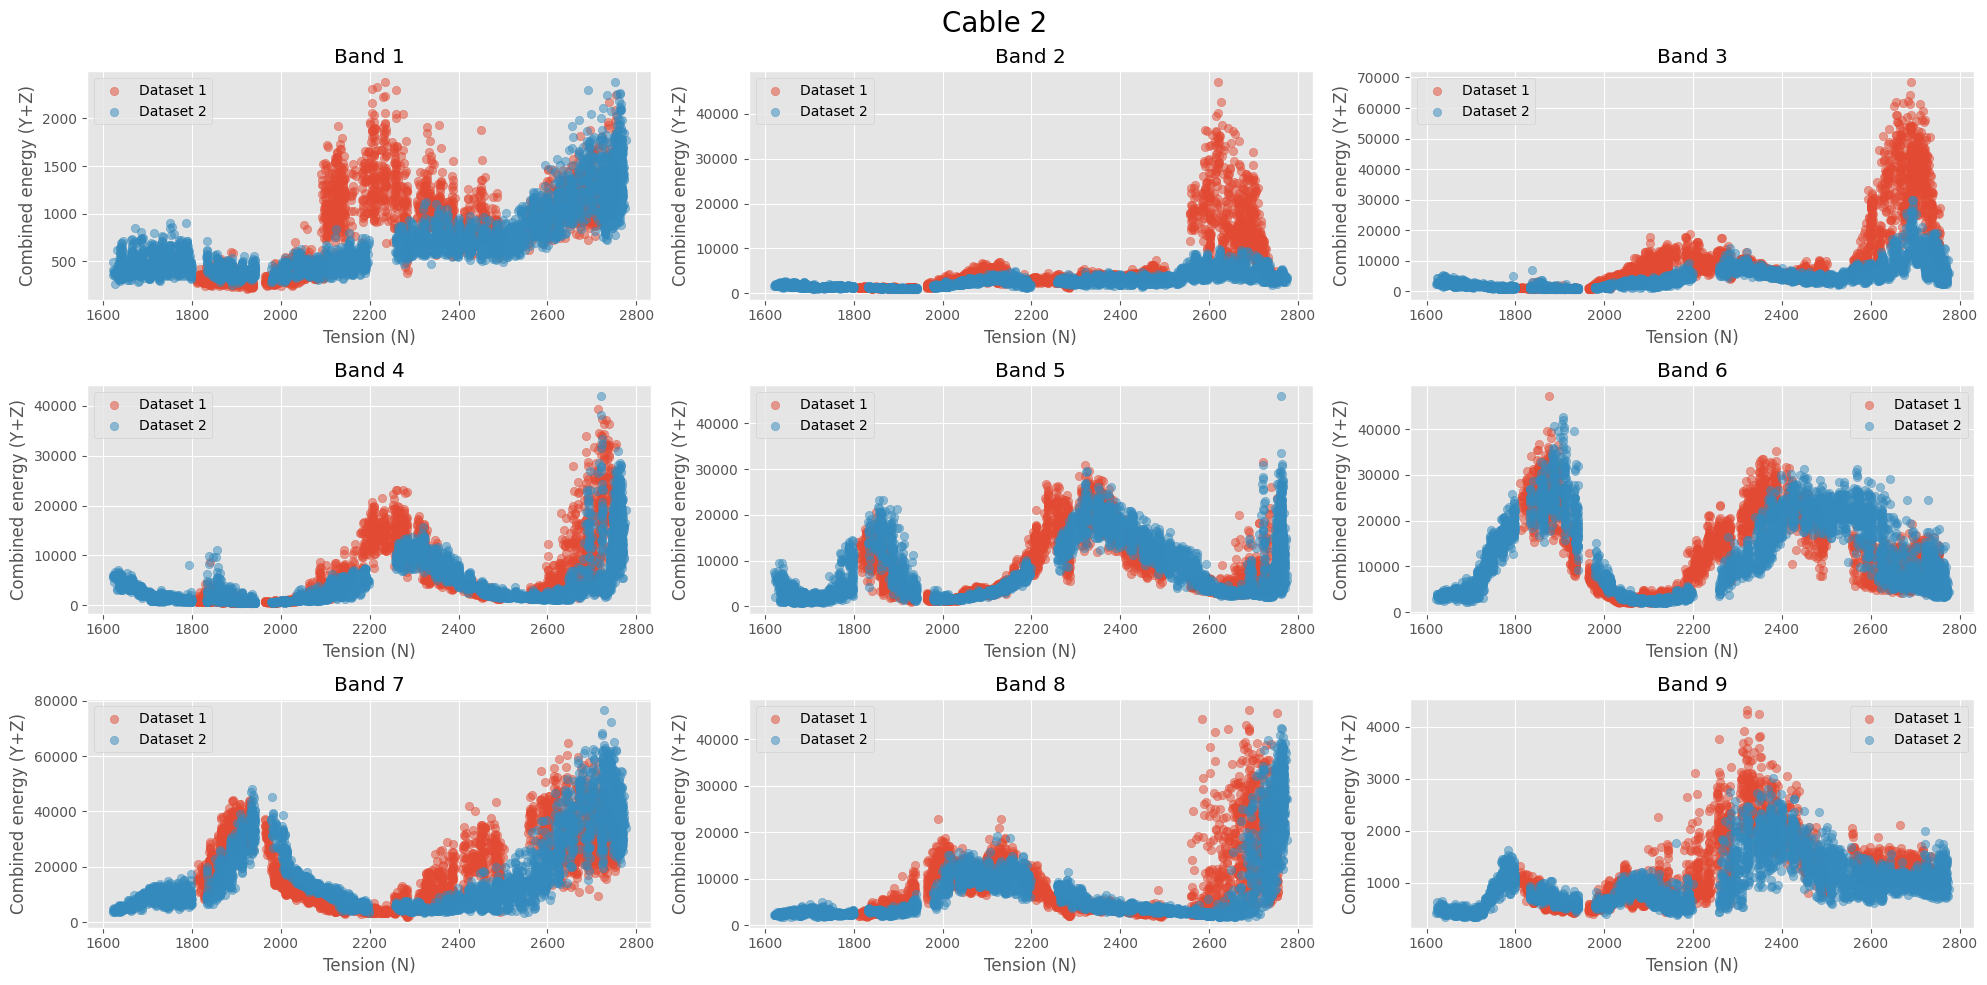

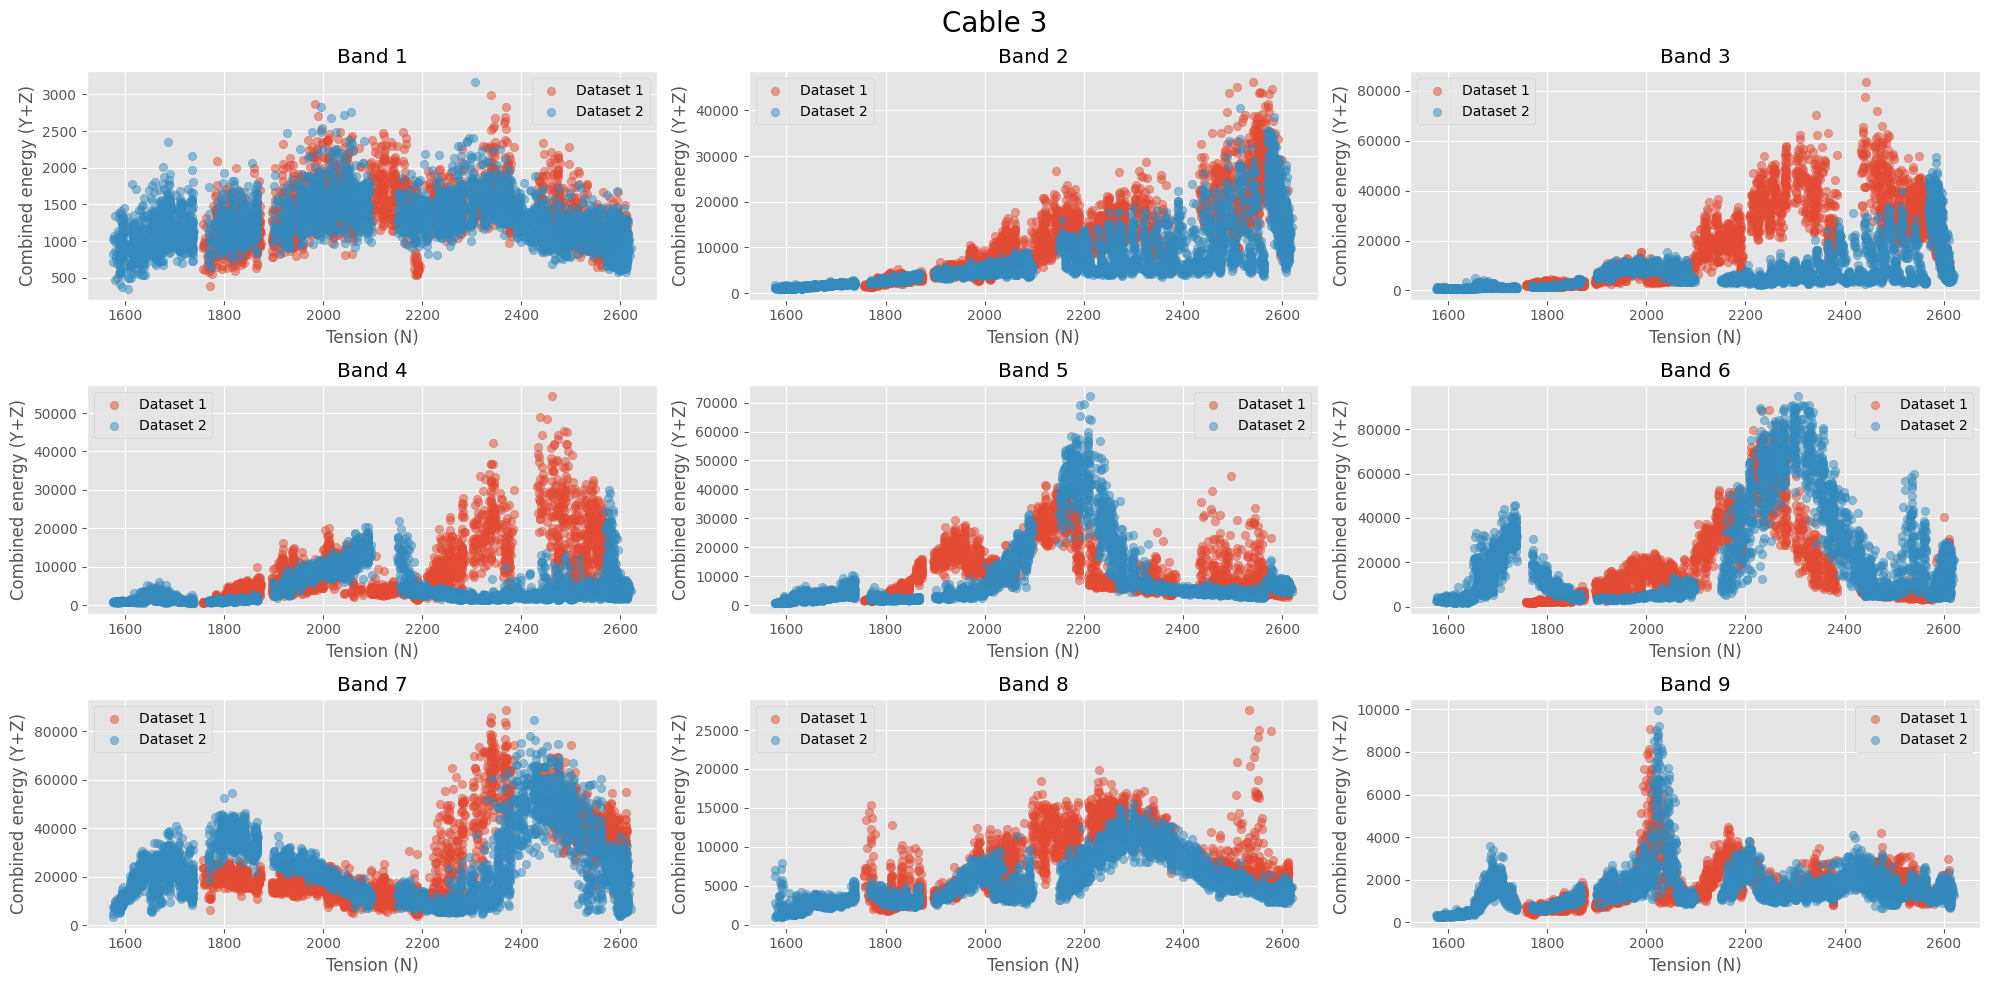

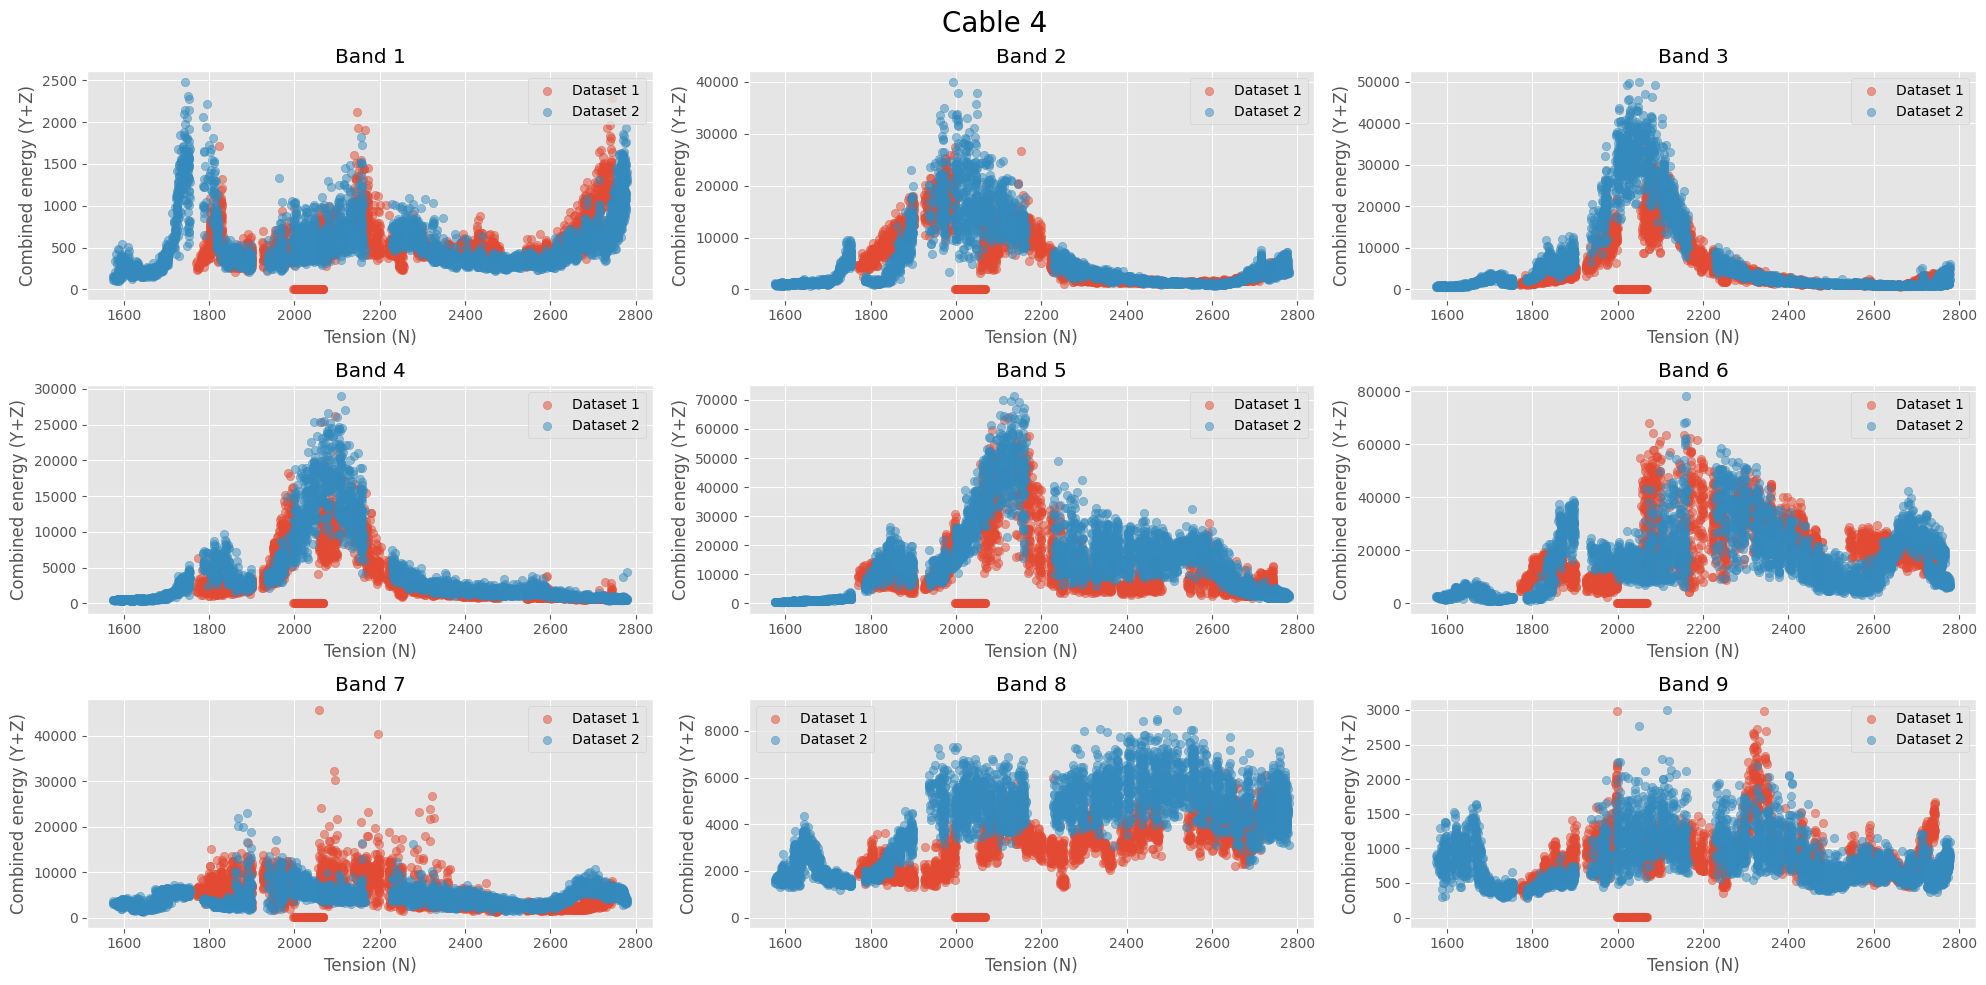

In [67]:
for cable in range(4):
    plt.figure(figsize=(20,10))
    plt.suptitle(f"Cable {cable+1}", fontsize=20)
    for band in range(len(band_pairs)): 
        plt.subplot(3,3,band+1)
        plt.title(f"Band {band+1}")
        plt.scatter(tensions_dataset_1[f"{cable}"], band_matrices_dataset_1[f"{cable}"][:,band], alpha=0.5)
        plt.scatter(tensions_dataset_2[f"{cable}"], band_matrices_dataset_2[f"{cable}"][:,band], alpha=0.5)
        plt.xlabel("Tension (N)")
        plt.ylabel("Combined energy (Y+Z)")
        plt.legend(["Dataset 1", "Dataset 2"])
    plt.tight_layout()

# Training one model per cable

Training: dataset 2

Testing: dataset 1

In [68]:
from hmmlearn.hmm import GMMHMM

In [78]:
def initialize_left_right(n_components):
    A = np.zeros((n_components, n_components))
    for i in range(n_components-1):
        A[i,i] = 0.5
        A[i,i+1] = 0.5
    A[-1,-1] = 1
    return A

In [80]:
def train_hmm(x, n_components, n_mix, type="left-right"):
    if type == "left_right":
        hmm = GMMHMM(n_components=n_components, n_mix=n_mix, init_params="smcw")
        hmm.transmat_ = initialize_left_right(n_components)
    else:
        hmm = GMMHMM(n_components=n_components, n_mix=n_mix)
    hmm.fit(x)
    return hmm

In [70]:
hmm_per_cable = {}
for cable in range(4):
    hmm_per_cable[f"c{cable}"] = train_hmm()